<a href="https://colab.research.google.com/github/Ju0s/Projects/blob/main/%5BPrj%5Dplayground_s4e1_240115_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv
/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv


## Contents
- [Data Exploration](#ch1)
- [Exploritory Data Analysis](#ch2)
- [Modeling](#ch3)
- [Hyperparameter Tuning and Cross Validation](#ch4)
- [Visualizations](#ch5)
- [Submission](#ch6)

### All the used libaries
- Numpy
- Pandas
- Matplotlib
- Seaborn
- Scikit-learn
- XGBoost
- warnings

### Models used to make predictions
- XGBoost Classifier
- GridSearchCV for Hyperparameter tuning

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import shap

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Matplotlib Customization: Set various styling parameters for Matplotlib
rc = {
    # background color
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    # edge color
    "axes.edgecolor": "#000000",
    # grid color
    "grid.color": "#EBEBE7" + "30",
    # font family
    "font.family": "serif",
    # label color
    "axes.labelcolor": "#000000",
    # tick colors
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    # The grid alpha (transparency) is set to 0.4
    "grid.alpha": 0.4,
}

sns.set(rc=rc)
# Seaborn Customization: Define a color palette that will be used by Seaborn for coloting the plots
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

# Colorama Styling:
# Style and Fore from the colorama library: can be used to apply styles and colors to console text
from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

# Matplotlib Style: Set the overall style of Matplotlib plots to 'fivethirtyeight', which is a predefined style resembling the plots used by the FiveThirtyEight website
plt.style.use('fivethirtyeight')

## Data Exploration: <a class='anchor' id='ch1'></a>
- The dataset for this competition (both train and test) was generated from a deep learning model trained on the Bank Customer Churn Prediction dataset. Feature distributions are close to, but not exactly the same, as the original.

### Data Description:
* Customer ID: A unique identifier for each customer
* Surname: The customer's surname or last name
* Credit Score: A numerical value representing the customer's credit score
* Geography: The country where the customer resides
* Gender: The customer's gender
* Age: The customer's age.
* Tenure: The number of years the customer has been with the bank
* Balance: The customer's account balance
* NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)
* HasCrCard: Whether the customer has a credit card
* IsActiveMember: Whether the customer is an active member
* EstimatedSalary: The estimated salary of the customer
* Exited: Whether the customer has churned (Target Variable)

In [ ]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')

origional_data = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')

### Train Data

In [ ]:
train_data.head(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0
9,9,15591721,Cattaneo,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0


In [ ]:
train_data.describe().T.style.background_gradient()
# style.background_gradient(): Color the background in a gradient style.


,count,mean,std,min,25%,50%,75%,max
id,165034.000000,82516.500000,47641.356500,0.000000,41258.250000,82516.500000,123774.750000,165033.000000
CustomerId,165034.000000,15692005.019026,71397.816791,15565701.000000,15633141.000000,15690169.000000,15756824.000000,15815690.000000
CreditScore,165034.000000,656.454373,80.103340,350.000000,597.000000,659.000000,710.000000,850.000000
Age,165034.000000,38.125888,8.867205,18.000000,32.000000,37.000000,42.000000,92.000000
Tenure,165034.000000,5.020353,2.806159,0.000000,3.000000,5.000000,7.000000,10.000000
Balance,165034.000000,55478.086689,62817.663278,0.000000,0.000000,0.000000,119939.517500,250898.090000
NumOfProducts,165034.000000,1.554455,0.547154,1.000000,1.000000,2.000000,2.000000,4.000000
HasCrCard,165034.000000,0.753954,0.430707,0.000000,1.000000,1.000000,1.000000,1.000000
IsActiveMember,165034.000000,0.497770,0.499997,0.000000,0.000000,0.000000,1.000000,1.000000
EstimatedSalary,165034.000000,112574.822734,50292.865585,11.580000,74637.570000,117948.000000,155152.467500,199992.480000


### Test Data

In [ ]:
test_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [ ]:
test_data.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
id,110023.000000,220045.000000,31761.048671,165034.000000,192539.500000,220045.000000,247550.500000,275056.000000
CustomerId,110023.000000,15692096.605101,71684.990992,15565701.000000,15632859.000000,15690175.000000,15756926.000000,15815690.000000
CreditScore,110023.000000,656.530789,80.315415,350.000000,597.000000,660.000000,710.000000,850.000000
Age,110023.000000,38.122205,8.861550,18.000000,32.000000,37.000000,42.000000,92.000000
Tenure,110023.000000,4.996637,2.806148,0.000000,3.000000,5.000000,7.000000,10.000000
Balance,110023.000000,55333.611354,62788.519675,0.000000,0.000000,0.000000,120145.605000,250898.090000
NumOfProducts,110023.000000,1.553321,0.544714,1.000000,1.000000,2.000000,2.000000,4.000000
HasCrCard,110023.000000,0.753043,0.431244,0.000000,1.000000,1.000000,1.000000,1.000000
IsActiveMember,110023.000000,0.495233,0.499980,0.000000,0.000000,0.000000,1.000000,1.000000
EstimatedSalary,110023.000000,112315.147765,50277.048244,11.580000,74440.325000,117832.230000,154631.350000,199992.480000


### Original Data

In [ ]:
origional_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
origional_data.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.000000,5000.500000,2886.895680,1.000000,2500.750000,5000.500000,7500.250000,10000.000000
CustomerId,10000.000000,15690940.569400,71936.186123,15565701.000000,15628528.250000,15690738.000000,15753233.750000,15815690.000000
CreditScore,10000.000000,650.528800,96.653299,350.000000,584.000000,652.000000,718.000000,850.000000
Age,10000.000000,38.921800,10.487806,18.000000,32.000000,37.000000,44.000000,92.000000
Tenure,10000.000000,5.012800,2.892174,0.000000,3.000000,5.000000,7.000000,10.000000
Balance,10000.000000,76485.889288,62397.405202,0.000000,0.000000,97198.540000,127644.240000,250898.090000
NumOfProducts,10000.000000,1.530200,0.581654,1.000000,1.000000,1.000000,2.000000,4.000000
HasCrCard,10000.000000,0.705500,0.455840,0.000000,0.000000,1.000000,1.000000,1.000000
IsActiveMember,10000.000000,0.515100,0.499797,0.000000,0.000000,1.000000,1.000000,1.000000
EstimatedSalary,10000.000000,100090.239881,57510.492818,11.580000,51002.110000,100193.915000,149388.247500,199992.480000


## Exploritory Data Analysis <a class='anchor' id='ch2'></a>
- Exploratory Data Analysis (EDA) is an analysis approach that identifies general patterns in the data. These patterns include outliers and features of the data that might be unexpected. EDA is an important first step in any data analysis.

### Null Values:
Missing data/Null values is defined as the values or data that is not stored (or not present) for some variable/s in the given dataset.Here is a list of popular strategies to handle missing values in a dataset

* Deleting the Missing Values
* Imputing the Missing Values
* Imputing the Missing Values for Categorical Features
* Imputing the Missing Values using Sci-kit Learn Library
Using “Missingness” as a Feature

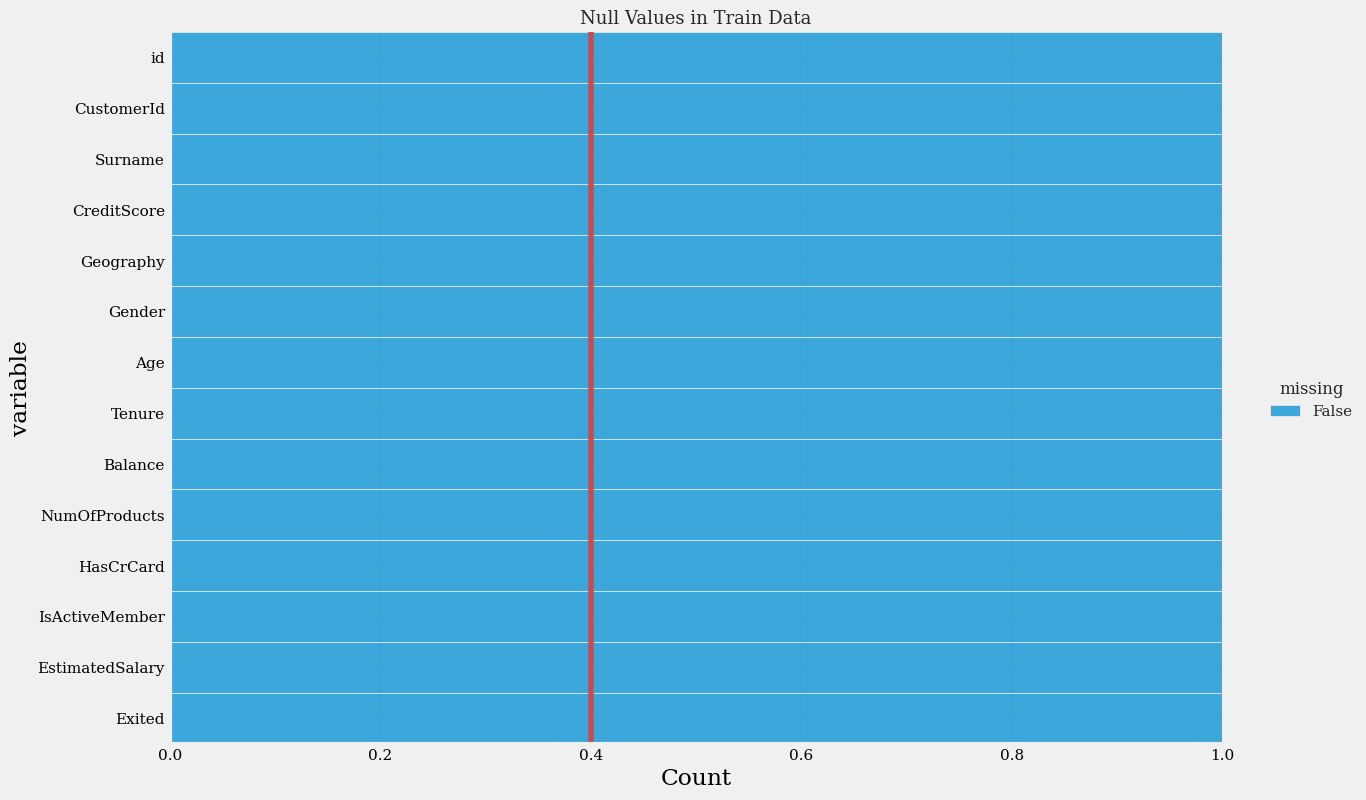

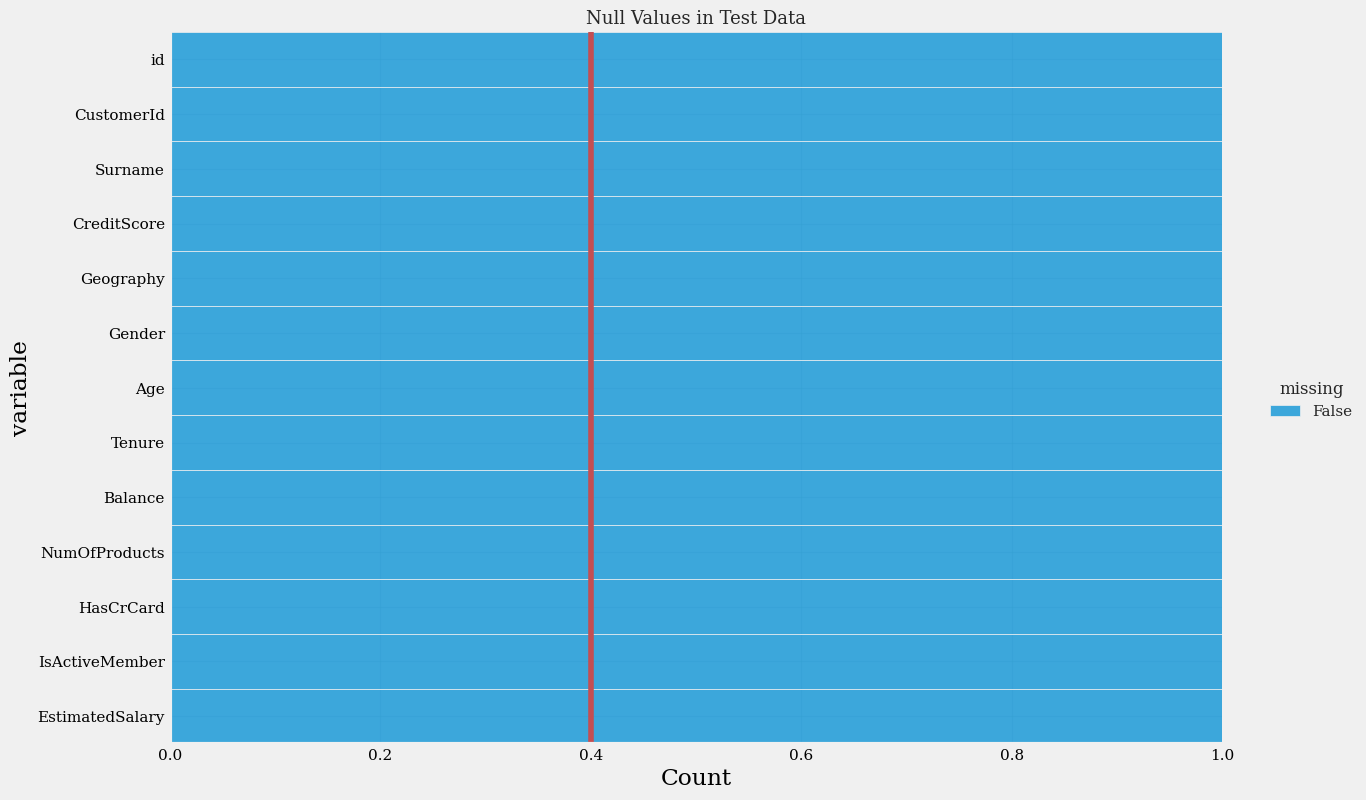

In [ ]:
# Display the distribution of missing values in the columns of 'train_data' and 'test_data'
# Add a vertical red line to indicate a threshold value of 0.4

# Plotting Missing Values in Train Data: create a distribution plot (y='variable') with color-filled areas representing missing values (hue='missing')
sns.displot(data=train_data.isnull().melt(value_name='missing'),  # Create a DataFrame where each row represents a missing value in 'train_data'
# displot(): Provide access to several approaches for visualizing the univariate or bivariate distribution of data
# insull(): Detect missing values for an arrya-like object
# melt(): Unpivot a DataFrame from wide to long format
#        This function is useful to massage a DataFrame into a format where one or more columns are identifier variables (id_vars),
#        while all other columns, considered measured variables (value_vars), are “unpivoted” to the row axis, leaving just two non-identifier columns, ‘variable’ and ‘value’.
    y='variable',
    hue='missing',  # Semantic variable that is mapped to determine the color of plot elements.
    multiple='fill',  # The areas are stacked and fill the entire plot
    height=8,
#     width=10,
    aspect=1.6  # Aspect ratio of each facet
)

# Specifying a threshold value
plt.axvline(0.4, color='r')  # Add a vertical red line at x-axis position 0.4, serving as a threshold for the proportion of missing values
# axvline: Add a vertical line across the Axes
plt.title('Null Values in Train Data', fontsize=13)
plt.show()

# -------------------------

# Plotting Missing Values in Test Data:
sns.displot(data=test_data.isnull().melt(value_name='missing'),
    y='variable',
    hue='missing',
    multiple='fill',
    height=8,
#     width=10,
    aspect=1.6
)

# Specifying a threshold value
plt.axvline(0.4, color='r')
plt.title('Null Values in Test Data', fontsize=13)
plt.show()

As we can see we have no null values in the both train and test data.

### Target Variable Analysis

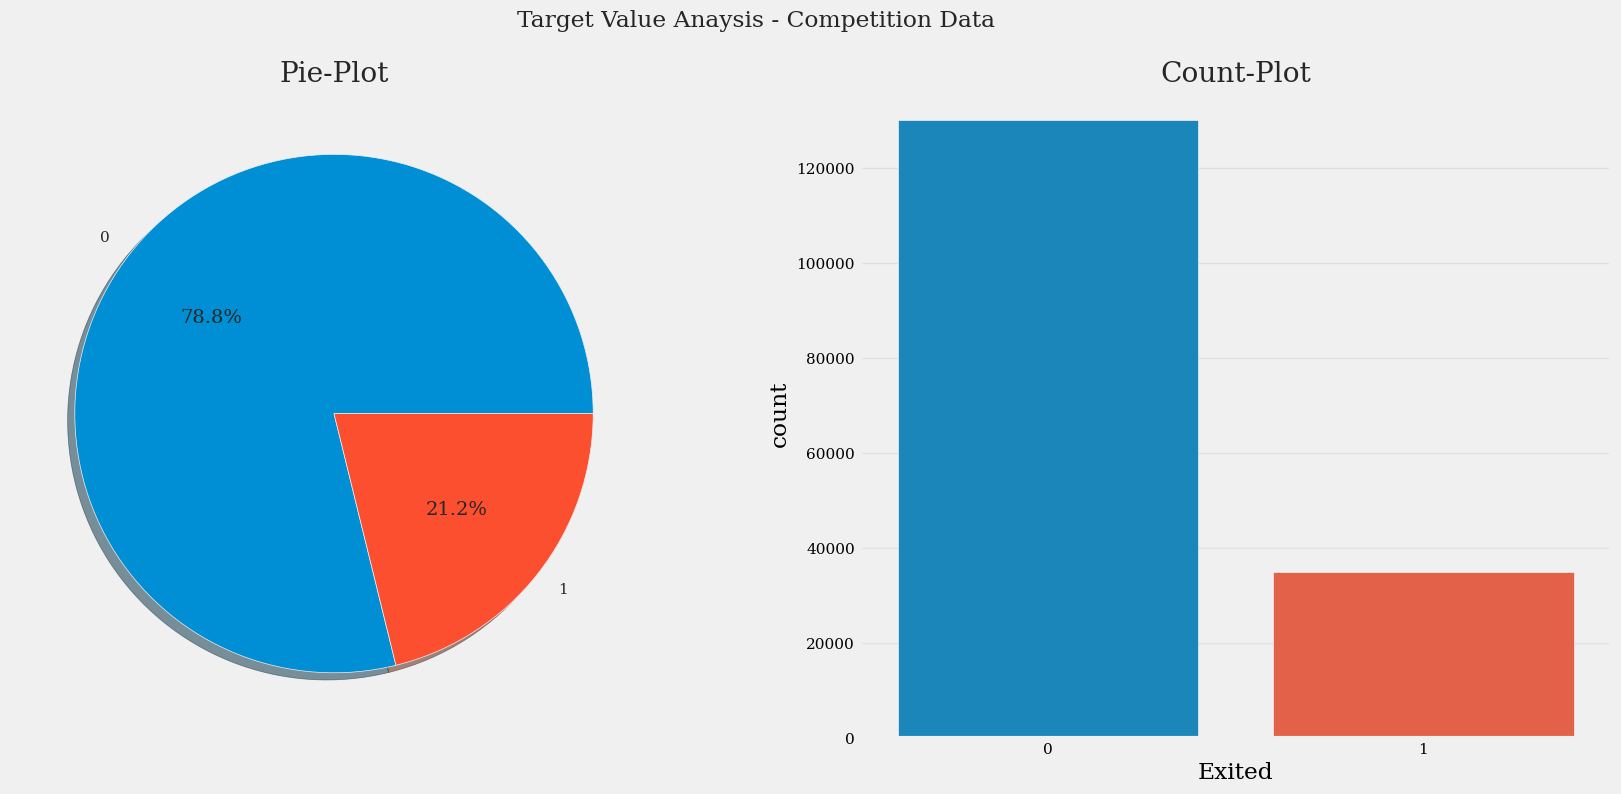

In [ ]:
# Create a figure with two subplots side by side to analyze the target variable('Exited') in the 'train_data'
# A pie plot and a count plot are used

# Creating Subplots:
f,ax=plt.subplots(1,2,figsize=(19,8))  # creates a figure (f) with one row and two columns of subplots (ax)

# Pie Plot for Target Variable ('Exited'):
train_data['Exited'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
# plot.pie(): Make a pie chart of array x. The fractional area of each wedge is given by x/sum(x). The wedges are plotted counterclockwise, by default starting from the x-axis.
# autopct: A string or function used to label the wedges with their numeric value. The label will be placed inside the wedge.

# Setting Titles and Labels for the First Subplot:
ax[0].set_title('Pie-Plot')
ax[0].set_ylabel('')

# Count Plot for Target Variable ('Exited'):
sns.countplot(x='Exited',data=train_data,ax=ax[1])
# countplot(): Show the counts of observations in each categorical bin using bars

# Setting Titles for the Second Subplot:
ax[1].set_title('Count-Plot')

# Super Title and Displaying the Plot:
plt.suptitle('Target Value Anaysis - Competition Data')
# suptitle: Add a centered suptitle to the figure
plt.show()

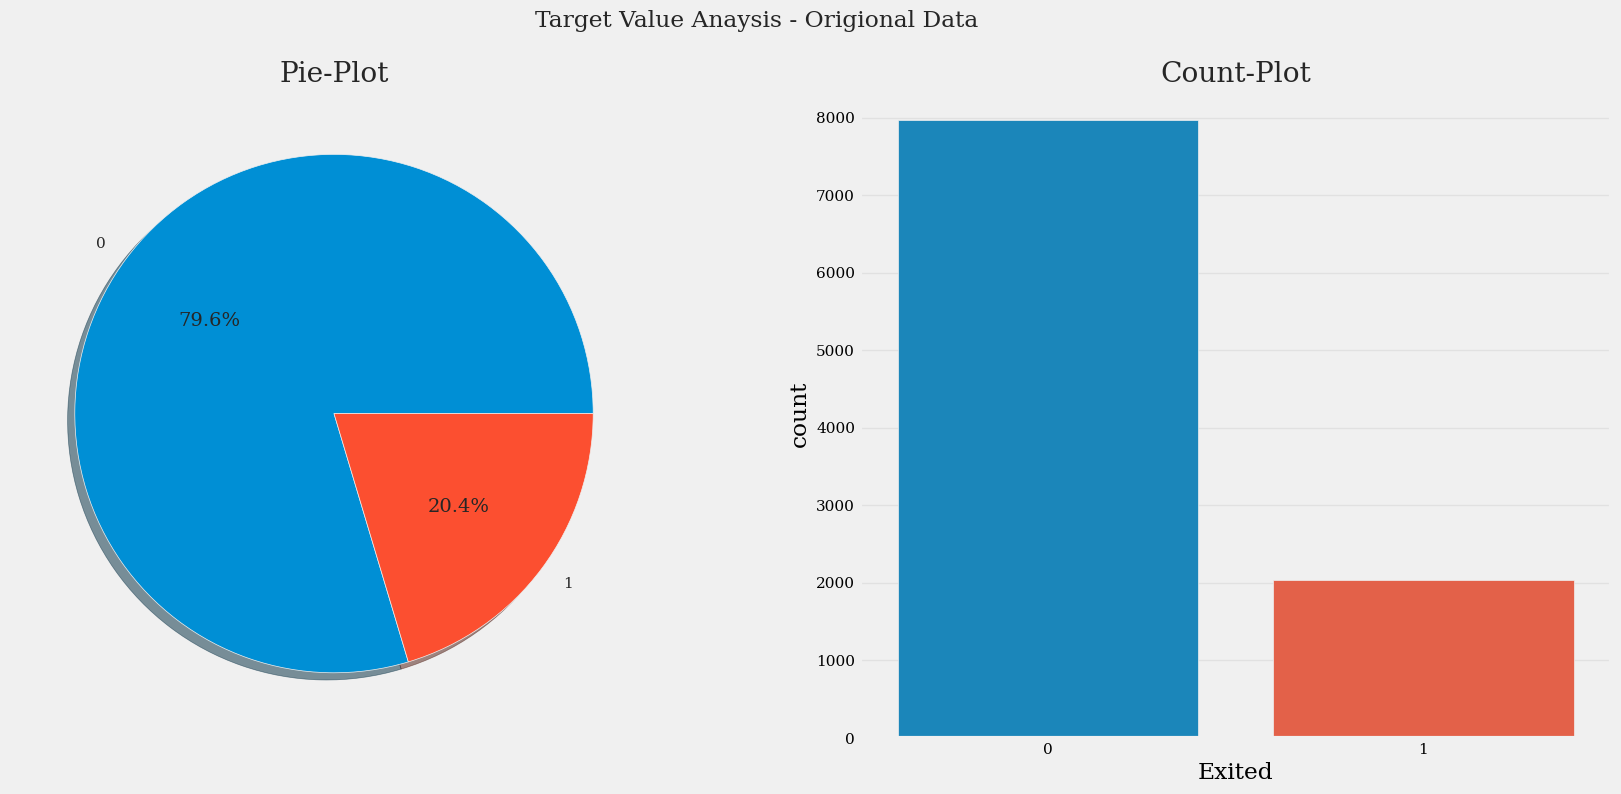

In [ ]:
f,ax=plt.subplots(1,2,figsize=(19,8))
origional_data['Exited'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Pie-Plot')
ax[0].set_ylabel('')
sns.countplot(x='Exited',data=origional_data,ax=ax[1])
ax[1].set_title('Count-Plot')
plt.suptitle('Target Value Anaysis - Origional Data')
plt.show()

Some Observations from above plots:
* Distribution of both classes Exited and Not Exited is almost same in both of the Origional and Competition Datasets.
* Also we can see that data is highly imbalanced. Almost 80% of our data is from class 0 (not exited) and 20% data is from class 1 (exited).
* In a real life also we only care about the persons or the people who are quitting or leaving (Exited) the bank and we only want to analyse the patterns of those people.

In [ ]:
# Categorize the columns in the train_data DataFrame into two groups: continuous (numerical) variables and categorical variables
# First, determine the number of unique values in each column
# And then apply a threshold (threshold = 12) to distinguish between continuous and categorical variables

# Unique value counts for each column
unique_counts = train_data.nunique()
# nunique(): Count number of distinct elements in specified axis. Return Series with number of distinct elements

# Threshold to distinguish continuous and categorical
threshold = 12

# Identify Continuous and Categorical Variables:
continuous_vars = unique_counts[unique_counts > threshold].index.tolist()
categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()

# Removing the 'outcome' from categorical since it's our target variable
if 'outcome' in categorical_vars:
    categorical_vars.remove('outcome')
if 'id' in continuous_vars:
    continuous_vars.remove('id')

print(f"Categorical Variables: {categorical_vars}")
print(f"Continousl/Numerical Variables: {continuous_vars}")

Categorical Variables: ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']
Continousl/Numerical Variables: ['CustomerId', 'Surname', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary']


### Categorical Variables Analysis:
In statistics, a categorical variable (also called qualitative variable) is a variable that can take on one of a limited, and usually fixed, number of possible values, assigning each individual or other unit of observation to a particular group or nominal category on the basis of some qualitative property. Categorical data is the statistical data type consisting of categorical variables or of data that has been converted into that form.

In our data categorical varibles are:

- Geography
- Gender
- Tenure
- NumOfProducts
- HasCrCard
- IsActiveMember

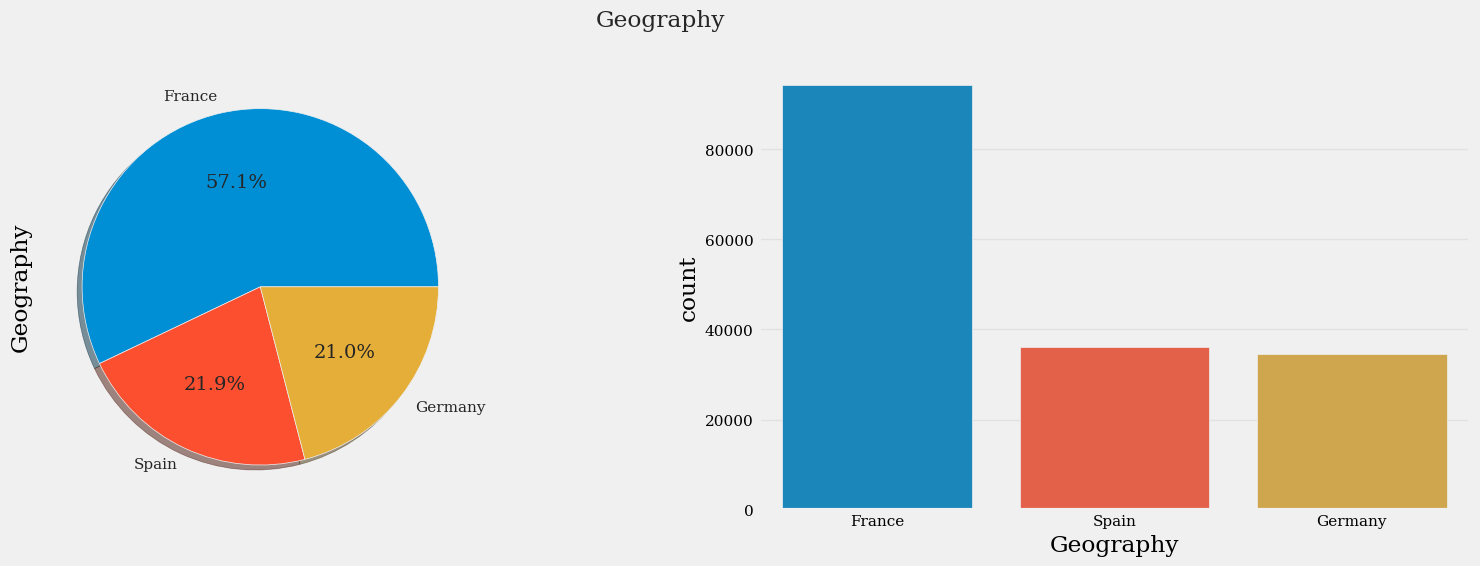

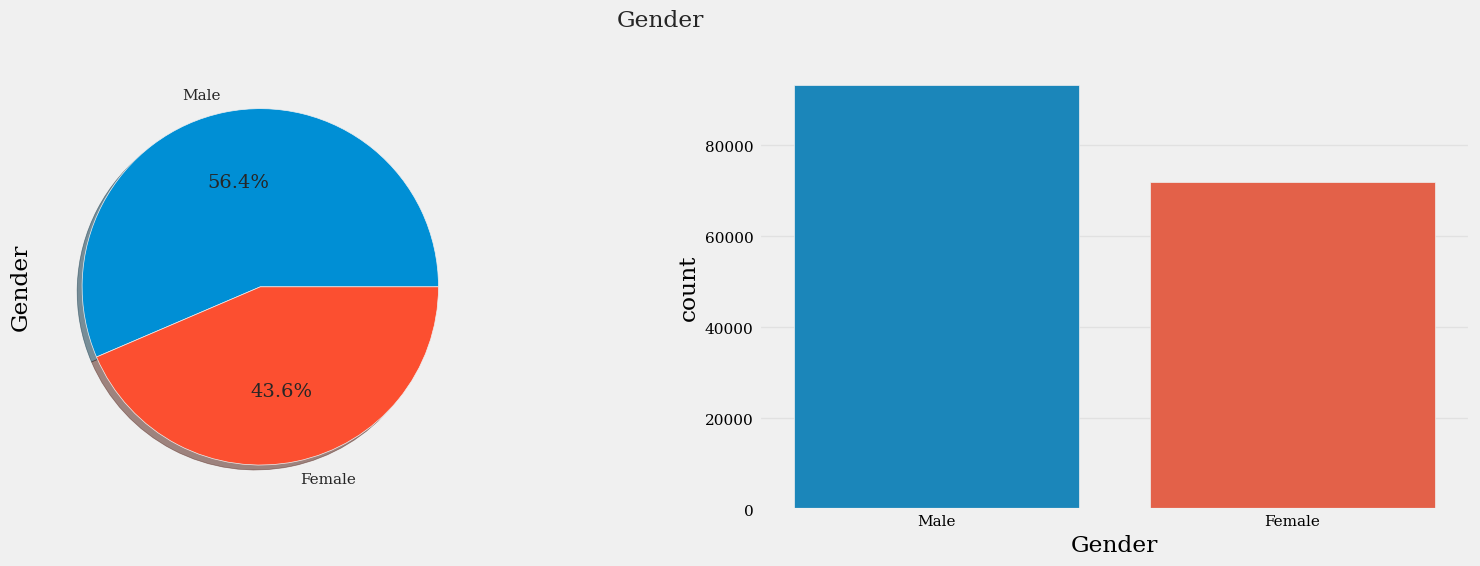

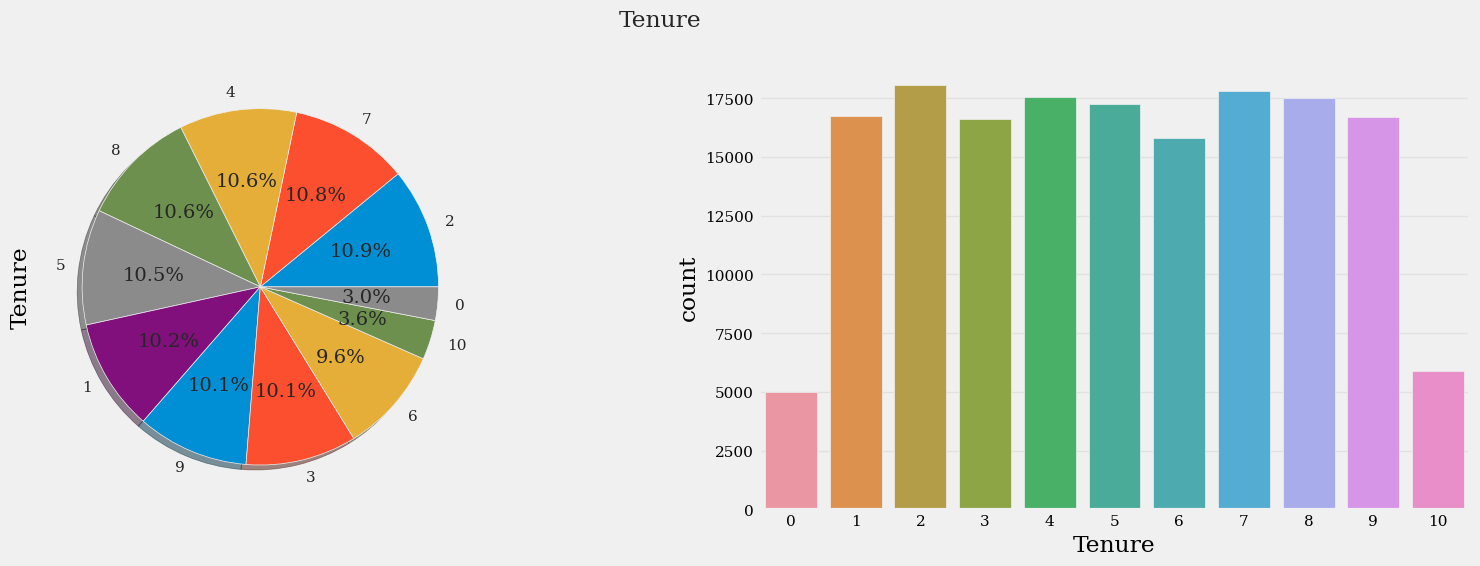

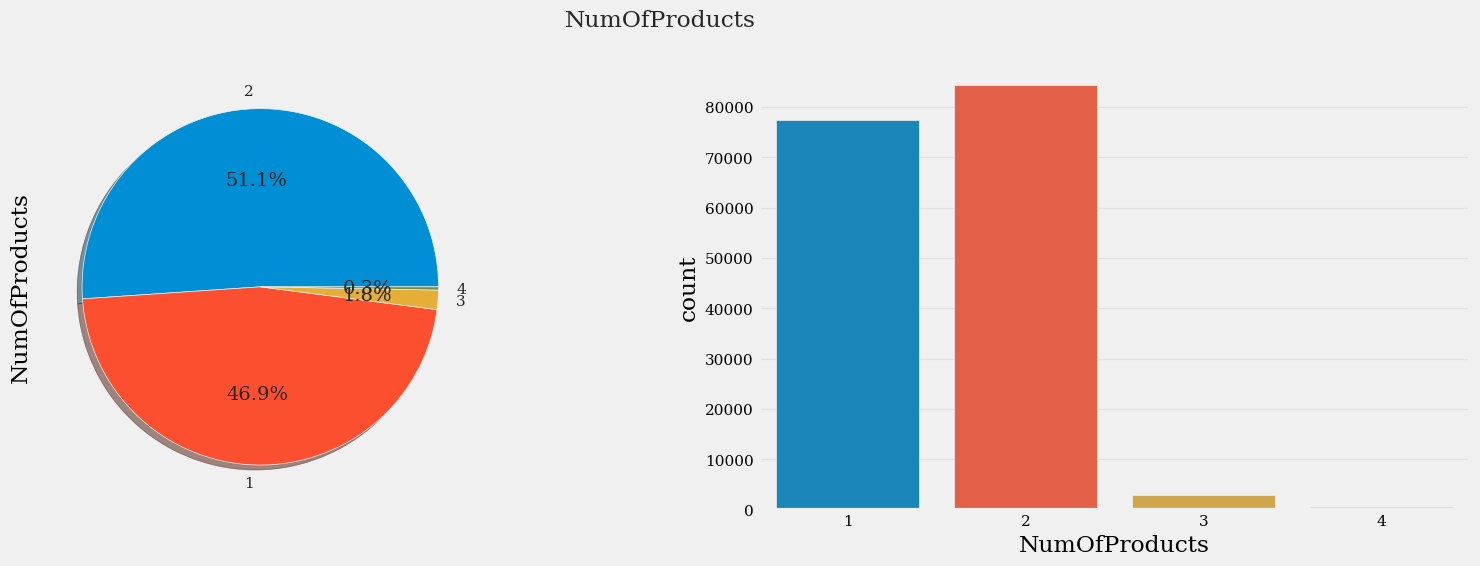

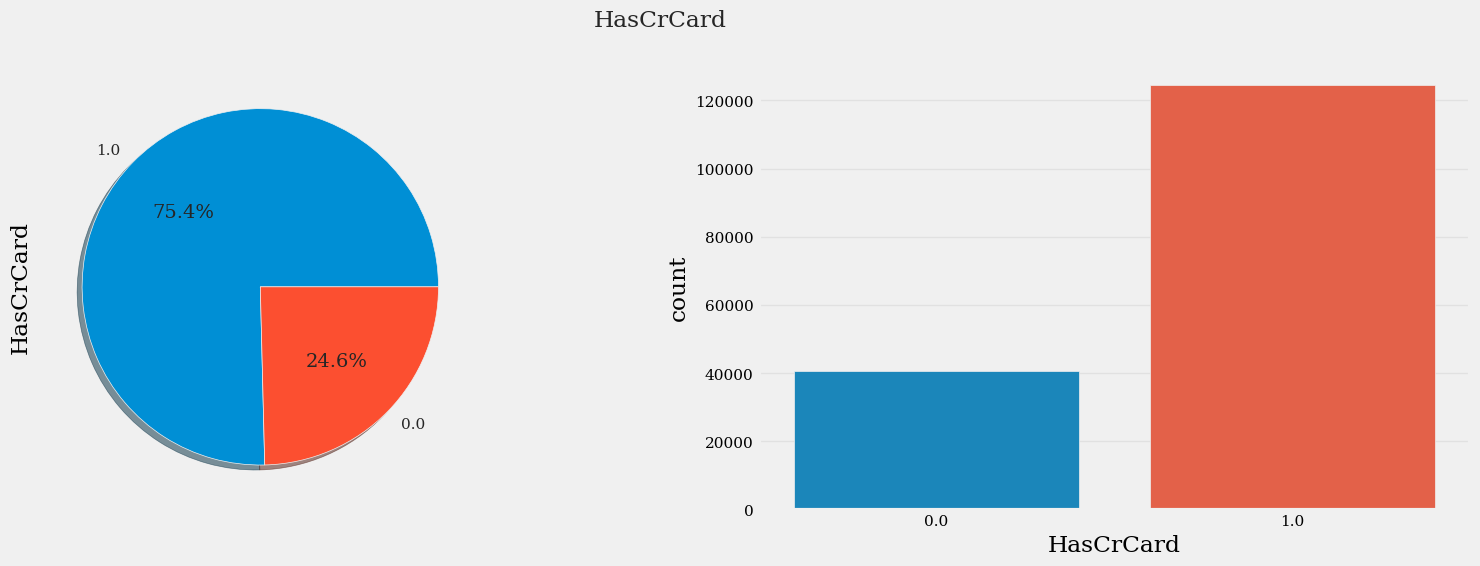

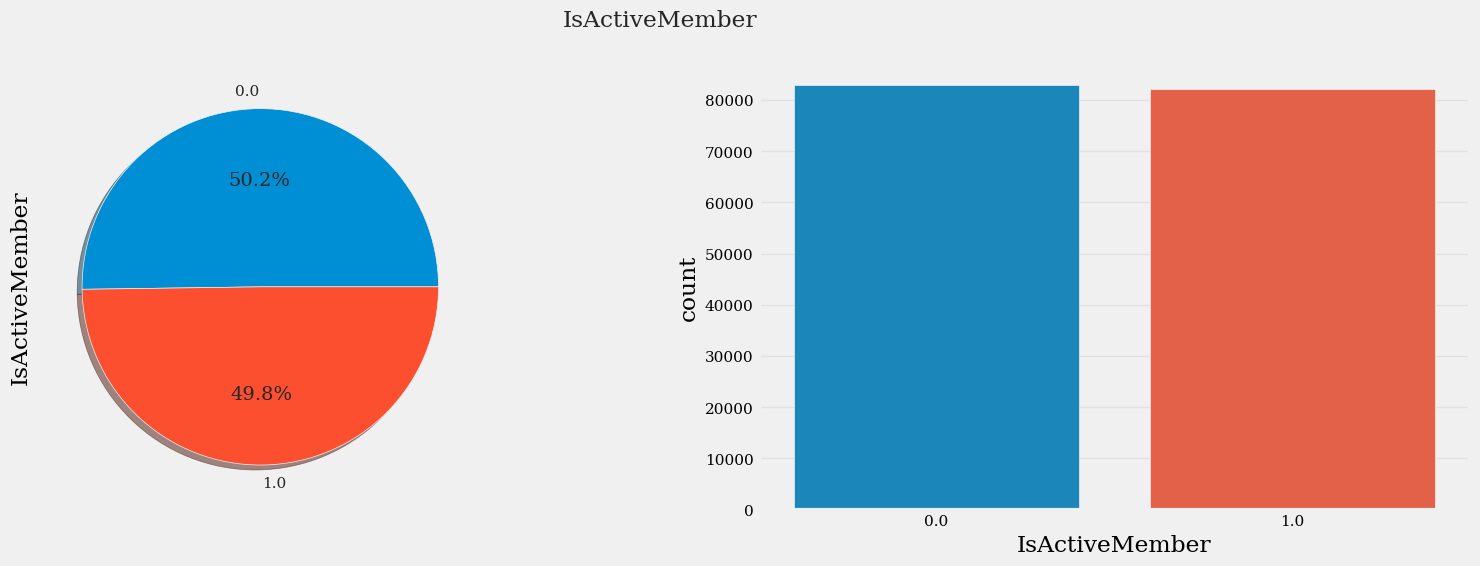

In [ ]:
# Remove 'Exited' from categorical_vars:
categorical_vars.remove('Exited')

# Generate Plots for Each Categorical Column:
for column in categorical_vars:
    f,ax=plt.subplots(1,2,figsize=(18,5.5))
    train_data[column].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
    ax[0].set_ylabel(f'{column}')
    sns.countplot(x=column,data=train_data,ax=ax[1])
    plt.suptitle(f'{column}')
    plt.show()

Some Observations from above plots:
* Some of the variables like IsActiveMember, Tenure and Gender are almost equaly distributed while the other variables like HasCrCard, NumOfProducts, and Gender are not equaly distributed.
* At first Tenure seems like continuous variable but it is a categorical variable with 11 classes from 0 to 10.

### Numerical Value Analysis:
In Mathematics, if a variable can take on two or more distinct real values so that it can also take all real values between them (even values that are randomly close together). In this case, the variable is continuous in the given interval. Continuous data is the statistical data type consisting of continuous variables or of data that has been converted into that form.

In our data Continuous variables are:

* CreditScore
* Age
* Balance
* EstimatedSalary

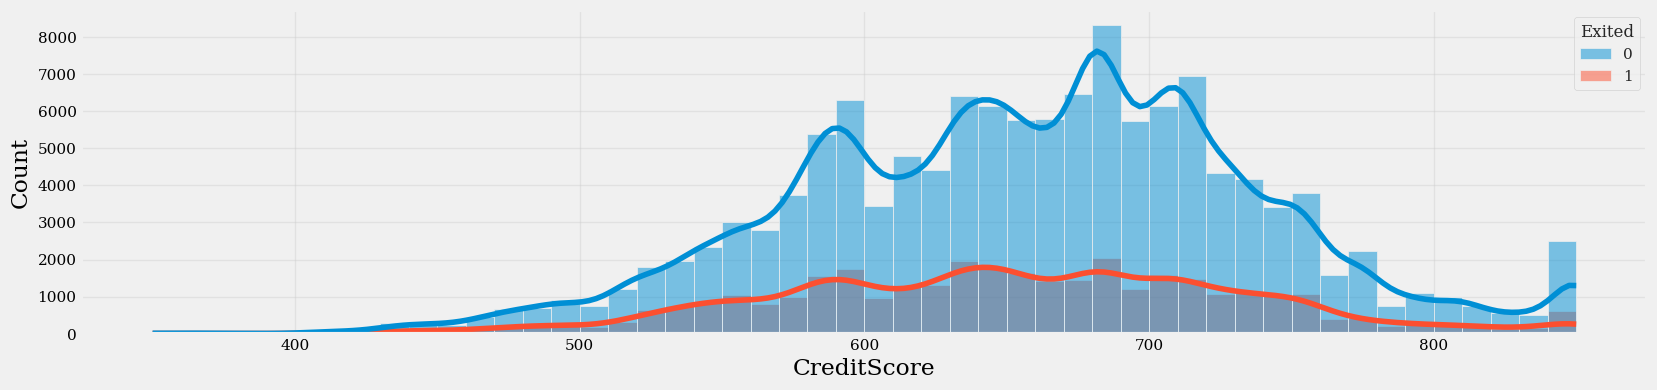

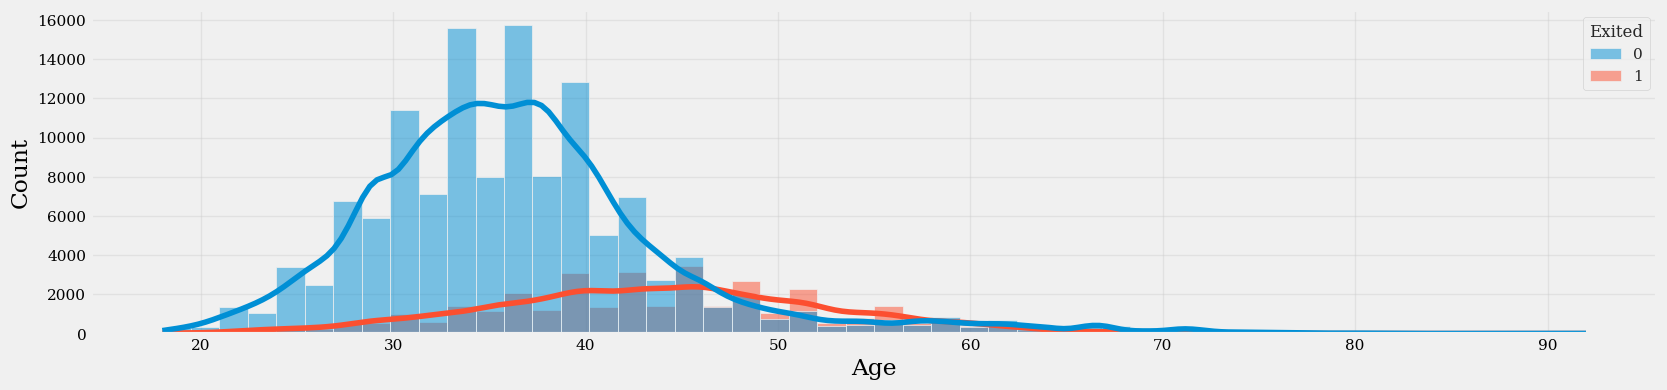

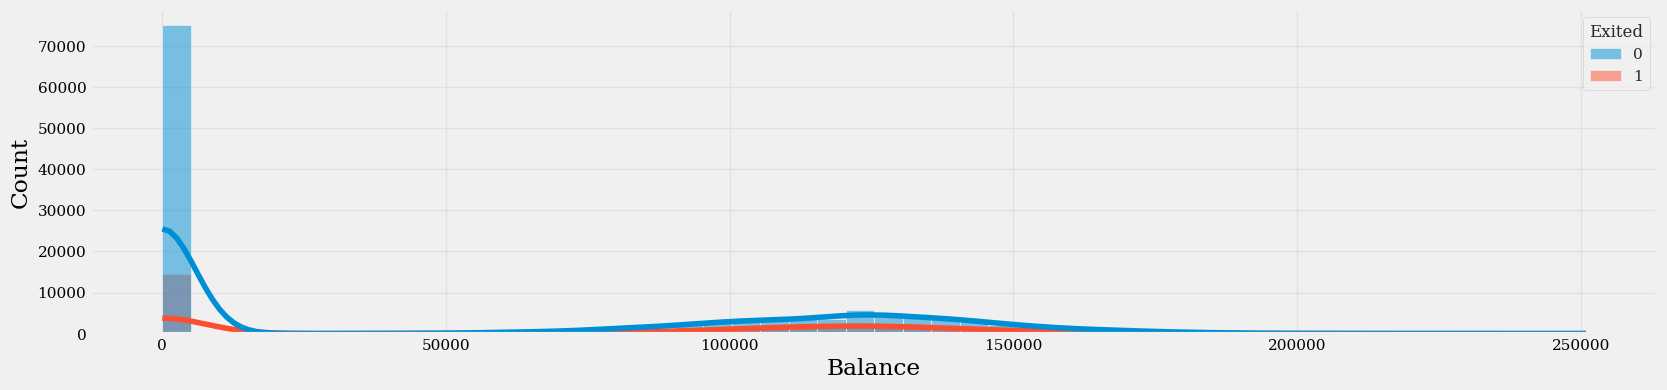

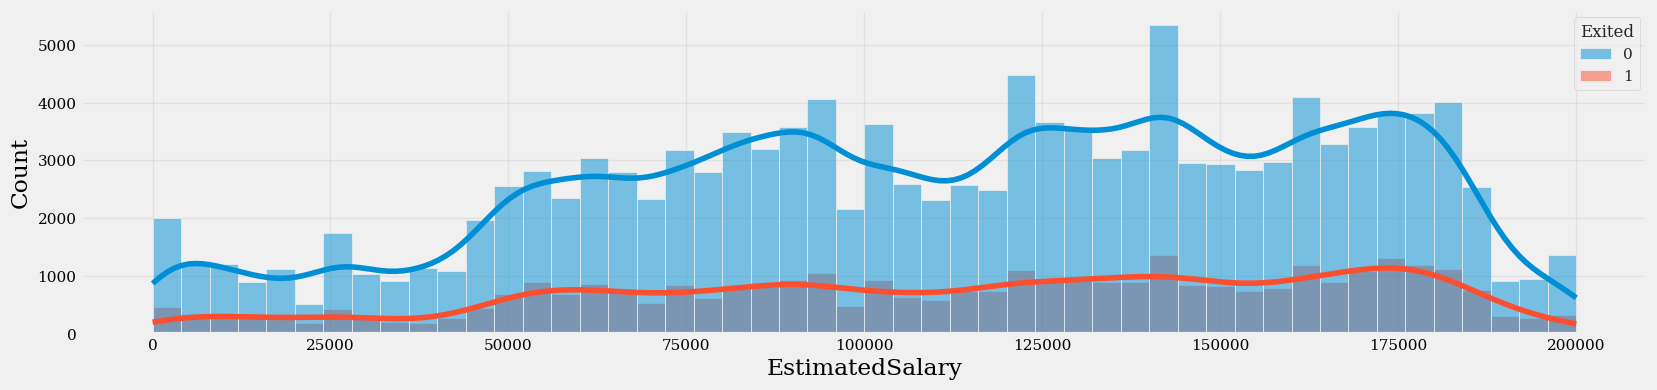

In [ ]:
# Remove 'CustomerId' and 'Surname' from continuous_vars:
continuous_vars.remove('CustomerId')
continuous_vars.remove('Surname')

# Generate Histograms for Each Continuous Column:
for column in continuous_vars:
    fig, ax = plt.subplots(figsize=(18, 4))
    fig = sns.histplot(data=train_data, x=column, hue="Exited", bins=50, kde=True)
    # histplot(): Plot univariate or bivariate histograms to show distributions of datasets
    # bins: Generic bin parameter that can be the name of a reference rule, the number of bins, or the breaks of the bins.
    # kde: If True, compute a kernel density estimate to smooth the distribution and show on the plot as (one or more) line(s). Only relevant with univariate data.
    plt.show()

Some Observations from above plots:
* Majority of the data from balance variable is 0 only which makes the distribution skewed to 0 side.
* Other variables also show the skewness in the distributions.
* Distribution of data for both classes is almost same for all the variables.

### Multivariate Analysis:
Multivariate analysis is based in observation and analysis of more than one statistical outcome variable at a time.

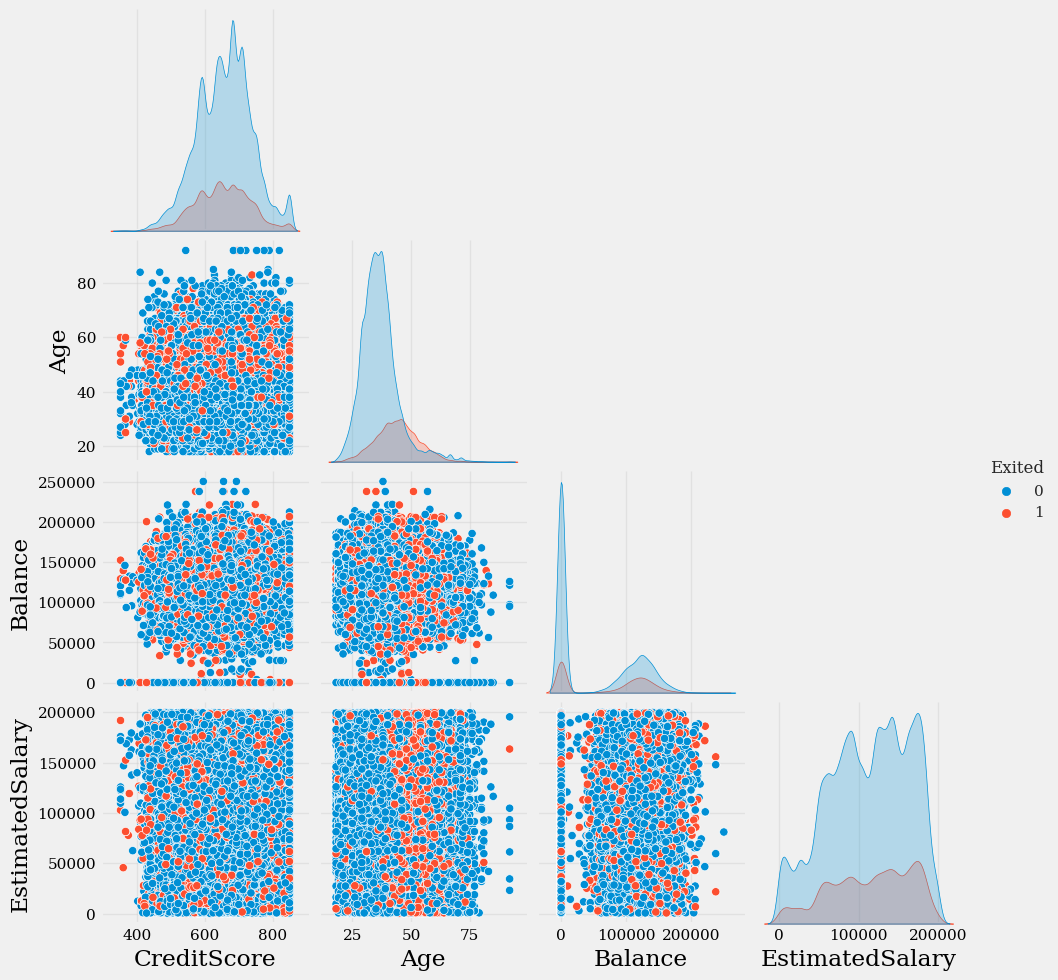

In [ ]:
df3 = train_data[['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']].copy()
sns.pairplot(df3, hue="Exited", corner=True)
# pairplot: Plot pairwise relationships in a dataset. By default, this function will create a grid of Axes
#           such that each numeric variable in data will by shared across the y-axes across a single row and the x-axes across a single column.
#           The diagonal plots are treated differently: a univariate distribution plot is drawn to show the marginal distribution of the data in each column.
#           It is also possible to show a subset of variables or plot different variables on the rows and columns.
# corner: If True, don’t add axes to the upper (off-diagonal) triangle of the grid, making this a “corner” plot.
plt.show()

### Correlation Analysis:
Correlation is the statistical analysis of the relationship or dependency between two variables. Correlation allows us to study both the strength and direction of the relationship between two sets of variables.

There are mainly 3 types of Correlations:

* Positive Correlation: Two variables are said to be positively correlated when their values move in the same direction.
* Neutral Correlation: No relationship in the change of variables X and Y. In this case, the values are completely random and do not show any sign of correlation.
* Negative Correlation: Finally, variables X and Y will be negatively correlated when their values change in opposite directions.

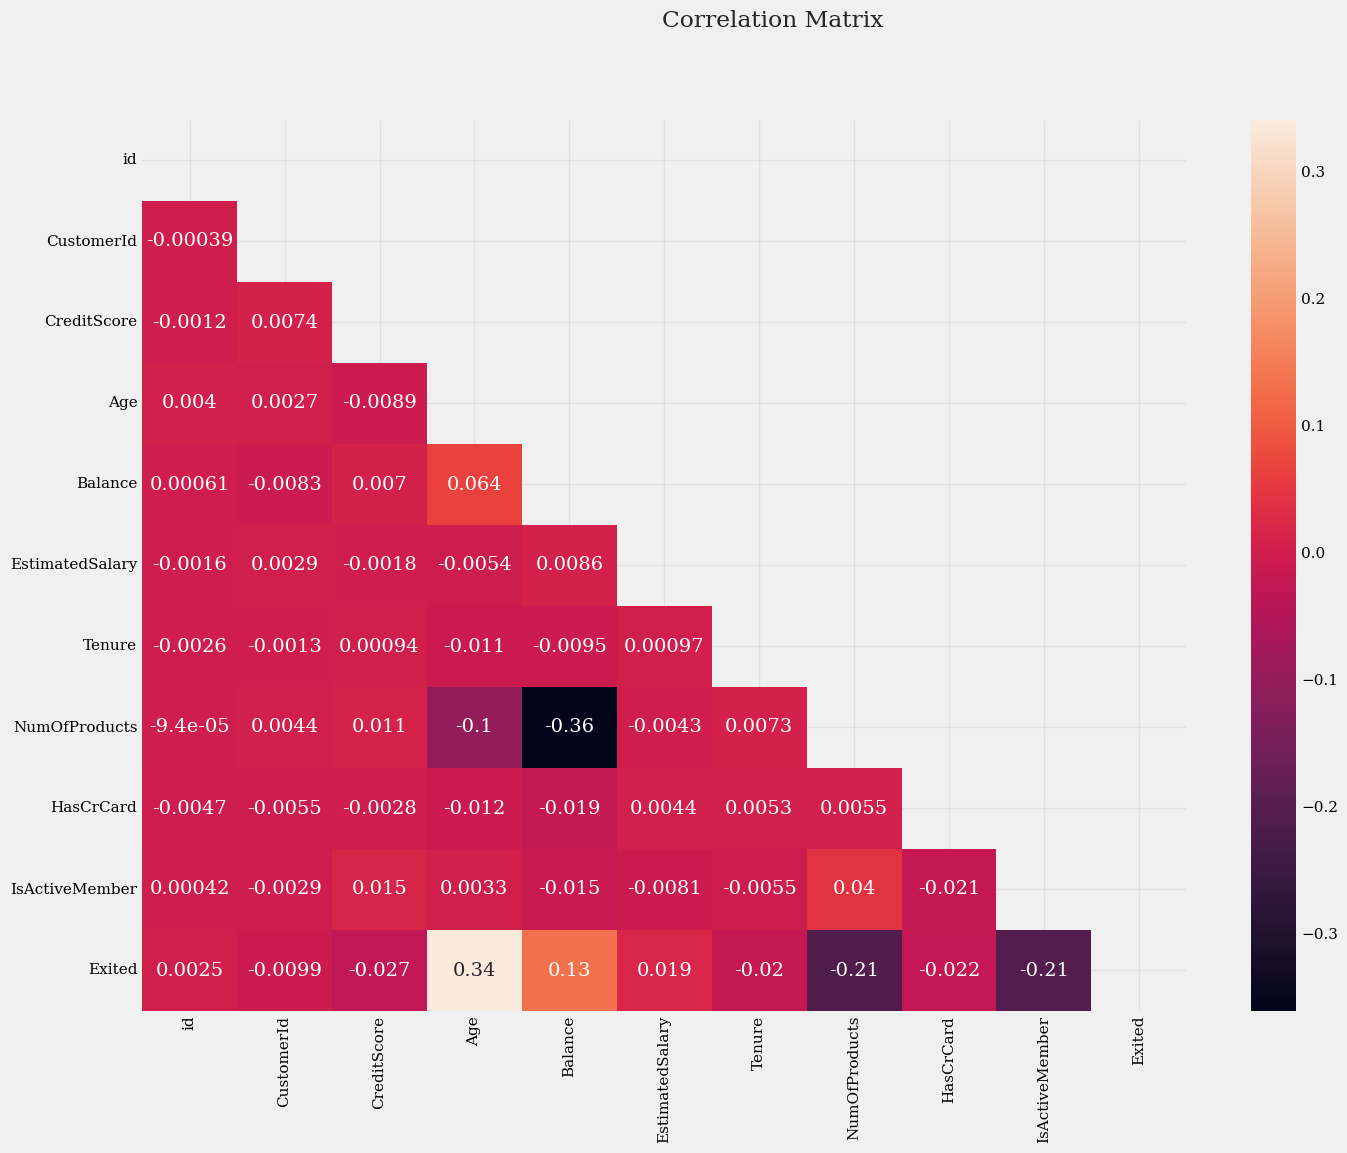

In [ ]:
# Create a heatmap to visualize the correlation matrix of selected variables in the train_data DataFrame

# Creating df4 DataFrame:
df4 = train_data[['id', 'CustomerId', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary',
       'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']].copy()

# Creating the Correlation Matrix:
corr_matrix=df4.corr()

# Creating a Mask:
mask = np.zeros_like(corr_matrix)  # Generate a matrix of zeros with the same shape as the correlation matrix
mask[np.triu_indices_from(mask)] = True  # Set the upper triangle part of the matrix to 1. Hide the upper triangle part of the heatmap.

f,ax=plt.subplots(figsize=(15,11))
sns.heatmap(corr_matrix, mask=mask, annot=True)
# annot: If True, write the data value in each cell
plt.suptitle('Correlation Matrix')
plt.show()

In [ ]:
# Exited ~ CreditScore + Age + Balance + EstimatedSalary + Tenure + NumOfProducts + HasCrCard + IsActiveMember
import statsmodels
import statsmodels.formula.api as smf

formula = 'Exited ~ CreditScore + Age + Balance + EstimatedSalary + Tenure + NumOfProducts + HasCrCard + IsActiveMember'
model = smf.ols(formula, df4).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Exited   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     4966.
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        13:20:06   Log-Likelihood:                -68600.
No. Observations:              165034   AIC:                         1.372e+05
Df Residuals:                  165025   BIC:                         1.373e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0313      0.010     -3.255      0.001      -0.050      -0.012
CreditScore        -0.0001   1.13e-05     -9.084      0.000      -0.000   -8.03e-05
Age                 0.0148      0.000    144.811      0.000       0.015       0.015
Balance          3.211e-07   1.54e-08     20.826      0.000    2.91e-07    3.51e-07
EstimatedSalary  1.453e-07   1.79e-08      8.096      0.000     1.1e-07    1.81e-07
Tenure             -0.0023      0.000     -7.009      0.000      -0.003      -0.002
NumOfProducts      -0.1158      0.002    -65.190      0.000      -0.119      -0.112
HasCrCard          -0.0198      0.002     -9.420      0.000      -0.024      -0.016
IsActiveMember     -0.1670      0.002    -92.416      0.000      -0.171      -0.163
==============================================================================
Omnibus:                    21005.900   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30173.312
Skew:                           1.042   Prob(JB):                         0.00
Kurtosis:                       3.207   Cond. No.                     1.46e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Project

### Data Exploration

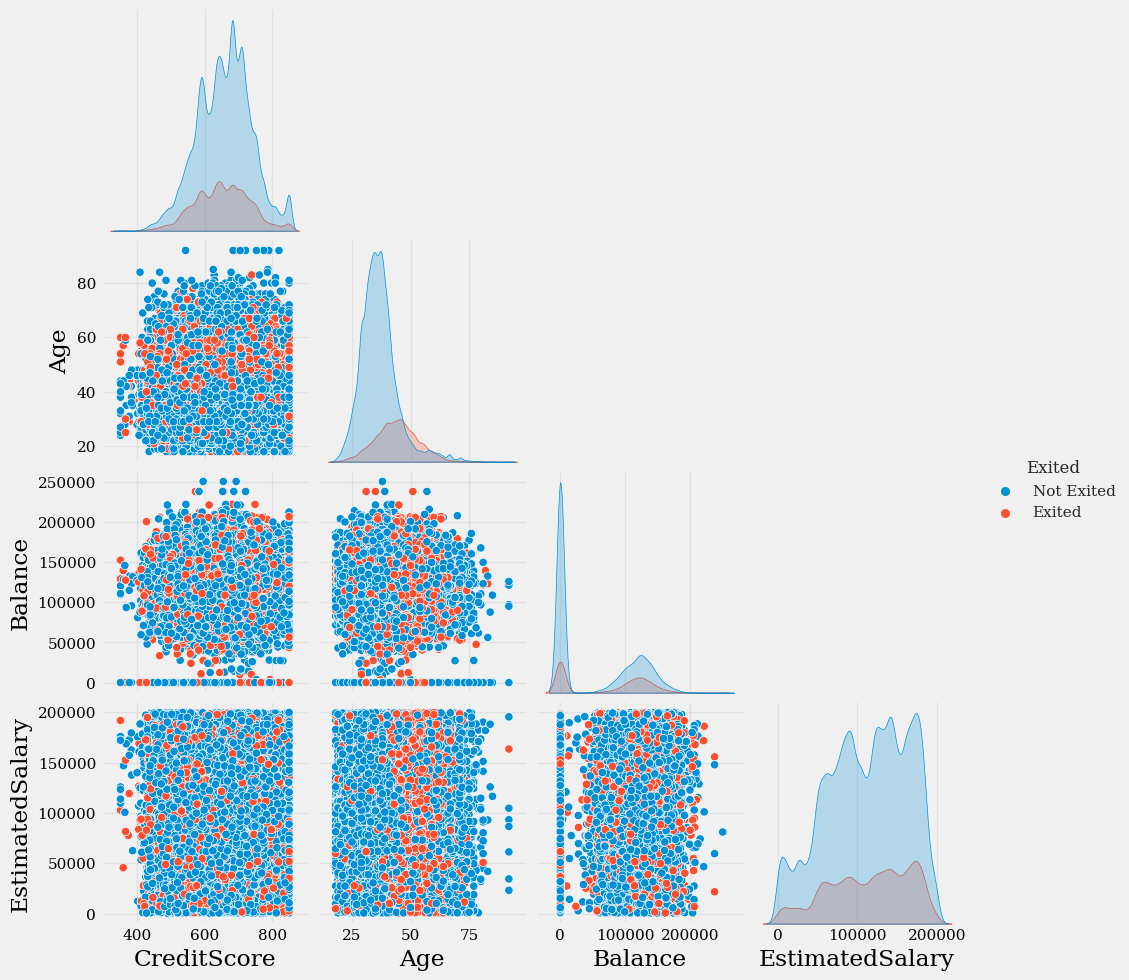

In [ ]:
# Load data
df3 = train_data[['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']].copy()

# Mapping dictionary for label changes
exit_label_mapping = {0: 'Not Exited', 1: 'Exited'}

# Change the values in the 'Exited' column using the mapping dictionary
df3['Exited'] = df3['Exited'].map(exit_label_mapping)

# Create a pairplot
sns.pairplot(df3, hue="Exited", corner=True)

# Show the plot
plt.show()

In [ ]:
# Age range
print(f"Age Range: {train_data['Age'].min()} ~ {train_data['Age'].max()}")

Age Range: 18.0 ~ 92.0


In [ ]:
# Grouping by age ranges

# Define the bins and corresponding labels for age groups
bins = [9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
age_labels = ['10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']

# Create a new column 'Ages' in the 'train_data' DataFrame based on the specified bins and labels
train_data['Ages'] = pd.cut(train_data['Age'], bins, labels=age_labels)

# Print the modified DataFrame
print(train_data)

            id  CustomerId         Surname  CreditScore Geography  Gender  \
0            0    15674932  Okwudilichukwu          668    France    Male   
1            1    15749177   Okwudiliolisa          627    France    Male   
2            2    15694510           Hsueh          678    France    Male   
3            3    15741417             Kao          581    France    Male   
4            4    15766172       Chiemenam          716     Spain    Male   
...        ...         ...             ...          ...       ...     ...   
165029  165029    15667085            Meng          667     Spain  Female   
165030  165030    15665521       Okechukwu          792    France    Male   
165031  165031    15664752            Hsia          565    France    Male   
165032  165032    15689614          Hsiung          554     Spain  Female   
165033  165033    15732798         Ulyanov          850    France    Male   

         Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  

In [ ]:
# Count the occurrences of each unique value in the 'Ages' column
train_data['Ages'].value_counts()

Ages
30s    81253
40s    43319
20s    23202
50s    12186
60s     3920
70s      763
10s      332
80s       48
90s       11
Name: count, dtype: int64

In [ ]:
# Create new datasets for each age group
group_10s = train_data.loc[train_data['Ages'] == '10s', :]
group_20s = train_data.loc[train_data['Ages'] == '20s', :]
group_30s = train_data.loc[train_data['Ages'] == '30s', :]
group_40s = train_data.loc[train_data['Ages'] == '40s', :]
group_50s = train_data.loc[train_data['Ages'] == '50s', :]
group_60s = train_data.loc[train_data['Ages'] == '60s', :]
group_70s = train_data.loc[train_data['Ages'] == '70s', :]
group_80s = train_data.loc[train_data['Ages'] == '80s', :]
group_90s = train_data.loc[train_data['Ages'] == '90s', :]

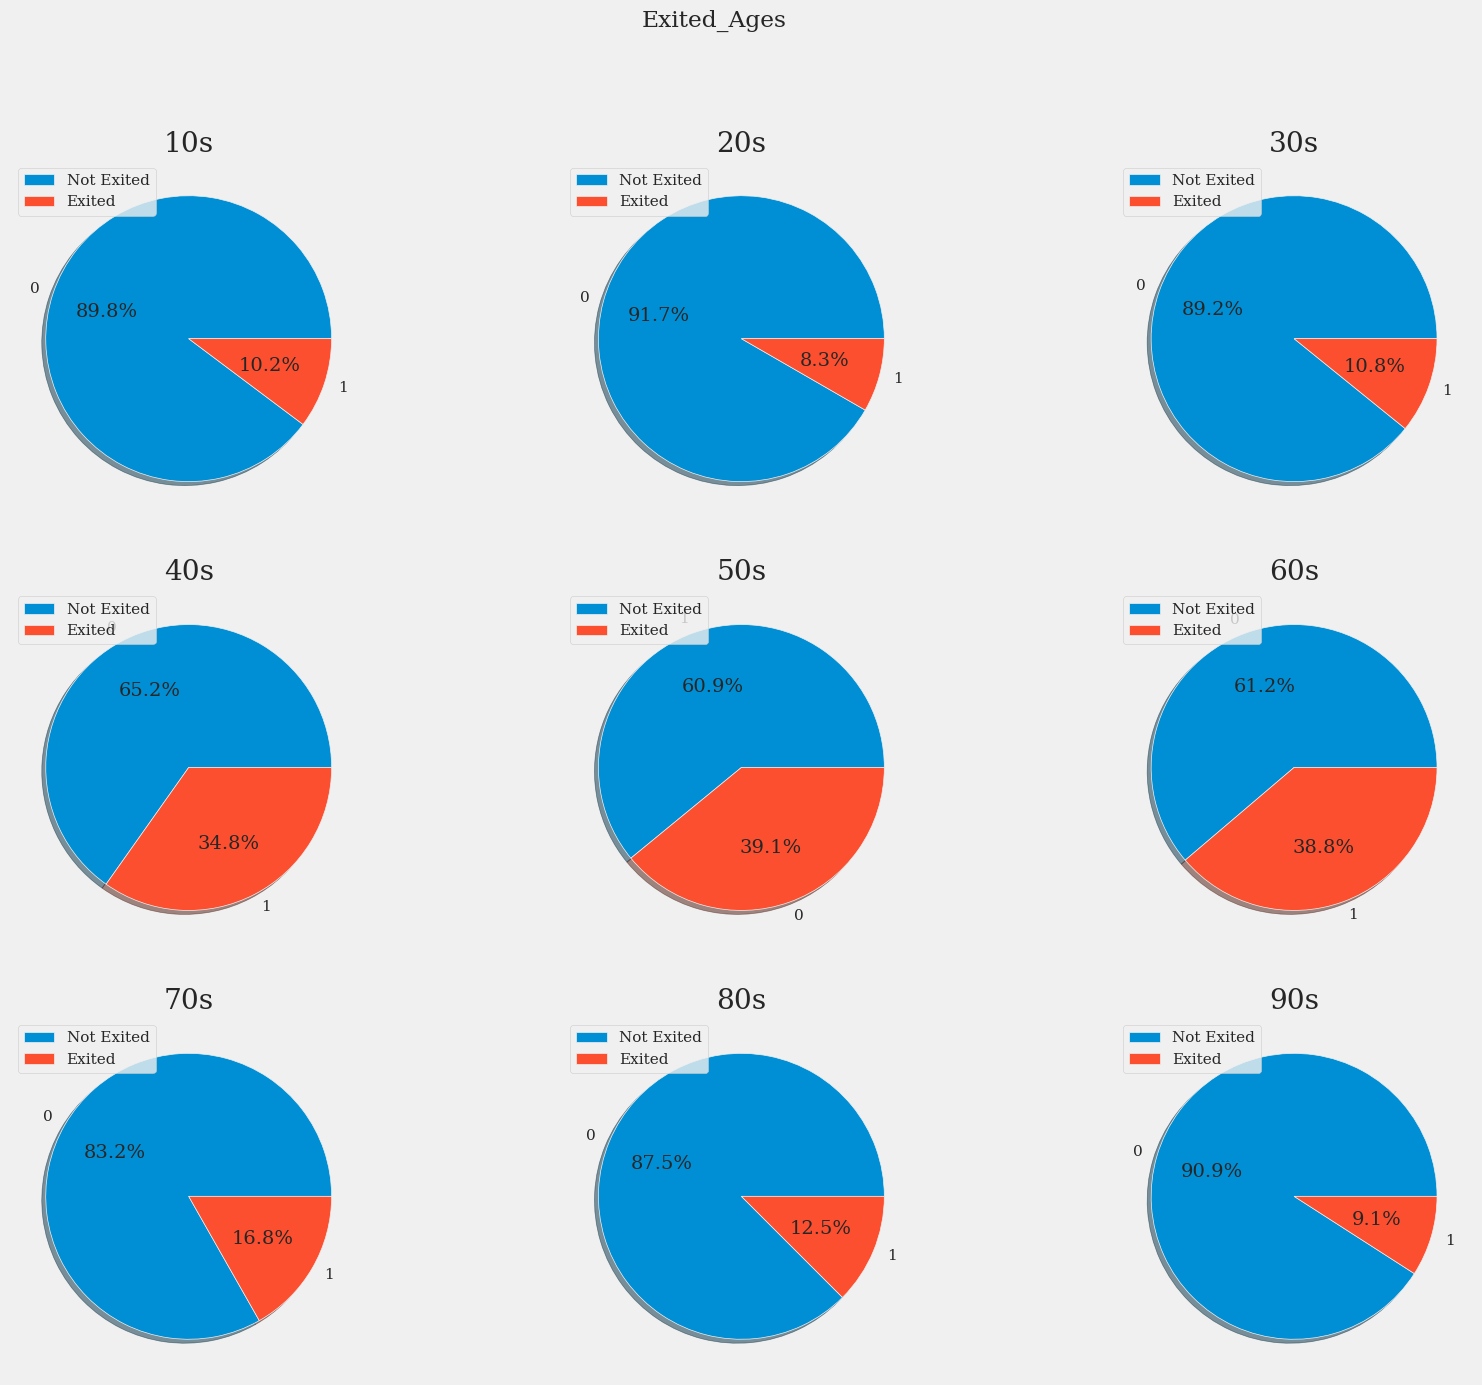

In [ ]:
# Create a 3x3 subplot grid
fig, ax = plt.subplots(3, 3, figsize=(18, 15))

# Define age groups and corresponding DataFrames
age_groups = {'10s': group_10s, '20s': group_20s, '30s': group_30s, '40s': group_40s,
              '50s': group_50s, '60s': group_60s, '70s': group_70s, '80s': group_80s, '90s': group_90s}

# Iterate over rows and columns of the subplot grid
for i, (age, group) in enumerate(age_groups.items()):
    row = i // 3
    col = i % 3

    # Plot pie chart for each age group
    pie_chart = group['Exited'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[row, col], shadow=True)
    ax[row, col].set_title(age)
    pie_chart.set_ylabel('')

    # Add legend for 'Not Exited' and 'Exited' at the top-left corner
    labels = ['Not Exited', 'Exited']
    ax[row, col].legend(labels, loc='upper left')

# Set the overall title for the entire figure
plt.suptitle('Exited_Ages')
plt.show()

### Chi-square test

In [ ]:
# Create datasets for customers who exited in their 30s and 40s
exited_30s = group_30s.loc[group_30s['Exited'] == 1, :]
exited_40s = group_40s.loc[group_40s['Exited'] == 1, :]

# Concatenate the data for exited customers in their 30s and 40s
exited_3040s = pd.concat([exited_30s, exited_40s])

In [ ]:
# Chi-square test for independence for Geography between exited customers in their 30s and 40s

# Importing necessary libraries
import numpy as np
from scipy.stats import chi2_contingency

# Creating a contingency table (cross-tab) for Ages and Geography
crcard_cross = pd.crosstab(exited_3040s['Ages'], exited_3040s['Geography'])

# Performing the Chi-square test for independence
chi2_geography, p_geography, dof, ef = chi2_contingency(crcard_cross, correction=False)

# Displaying the test statistics
print(f'Chi-square = {chi2_geography:.3f}')
print(f'p = {p_geography:.3f}')

# Interpreting the result based on the p-value
alpha = 0.05
if p_geography < alpha:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Chi-square = 21.585
p = 0.000
Reject the null hypothesis.


In [ ]:
# Chi-square test for independence for Gender between exited customers in their 30s and 40s

# Creating a contingency table (cross-tab) for Ages and Gender
crcard_cross = pd.crosstab(exited_3040s['Ages'], exited_3040s['Gender'])

# Performing the Chi-square test for independence
chi2_gender, p_gender, dof, ef = chi2_contingency(crcard_cross, correction=False)

# Displaying the test statistics
print(f'Chi-square = {chi2_gender:.3f}')
print(f'p = {p_gender:.3f}')

# Interpreting the result based on the p-value
alpha = 0.05
if p_gender < alpha:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Chi-square = 14.056
p = 0.000
Reject the null hypothesis.


In [ ]:
# Chi-square test for independence for Tenure between exited customers in their 30s and 40s

# Creating a contingency table (cross-tab) for Ages and Tenure
crcard_cross = pd.crosstab(exited_3040s['Ages'], exited_3040s['Tenure'])

# Performing the Chi-square test for independence
chi2_tenure, p_tenure, dof, ef = chi2_contingency(crcard_cross, correction=False)

# Displaying the test statistics
print(f'Chi-square = {chi2_tenure:.3f}')
print(f'p = {p_tenure:.3f}')

# Interpreting the result based on the p-value
alpha = 0.05
if p_tenure < alpha:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Chi-square = 18.167
p = 0.052
Fail to reject the null hypothesis.


In [ ]:
# Chi-square test for independence for NumOfProducts between exited customers in their 30s and 40s

# Creating a contingency table (cross-tab) for Ages and NumOfProducts
crcard_cross = pd.crosstab(exited_3040s['Ages'], exited_3040s['NumOfProducts'])

# Performing the Chi-square test for independence
chi2_products, p_products, dof, ef = chi2_contingency(crcard_cross, correction=False)

# Displaying the test statistics
print(f'Chi-square = {chi2_products:.3f}')
print(f'p = {p_products:.3f}')

# Interpreting the result based on the p-value
alpha = 0.05
if p_products < alpha:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Chi-square = 44.150
p = 0.000
Reject the null hypothesis.


In [ ]:
# Chi-square test for independence for HasCrCard between exited customers in their 30s and 40s

# Creating a contingency table (cross-tab) for Ages and HasCrCard
crcard_cross = pd.crosstab(exited_3040s['Ages'], exited_3040s['HasCrCard'])

# Performing the Chi-square test for independence
chi2_crcard, p_crcard, dof, ef = chi2_contingency(crcard_cross, correction=False)

# Displaying the test statistics
print(f'Chi-square = {chi2_crcard:.3f}')
print(f'p = {p_crcard:.3f}')

# Interpreting the result based on the p-value
alpha = 0.05
if p_crcard < alpha:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Chi-square = 21.744
p = 0.000
Reject the null hypothesis.


In [ ]:
# Chi-square test for independence for IsActiveMember between exited customers in their 30s and 40s

# Creating a contingency table (cross-tab) for Ages and IsActiveMember
crcard_cross = pd.crosstab(exited_3040s['Ages'], exited_3040s['IsActiveMember'])

# Performing the Chi-square test for independence
chi2_active, p_active, dof, ef = chi2_contingency(crcard_cross, correction=False)

# Displaying the test statistics
print(f'Chi-square = {chi2_active:.3f}')
print(f'p = {p_active:.3f}')

# Interpreting the result based on the p-value
alpha = 0.05
if p_active < alpha:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Chi-square = 40.818
p = 0.000
Reject the null hypothesis.


### Independent samples t-test

In [ ]:
# Testing homogeneity of variances for CreditScore between exited customers in their 30s and 40s

# Importing the Bartlett test
from scipy.stats import bartlett

# Performing Bartlett test for homogeneity of variances
statistic, p_value = bartlett(exited_30s['CreditScore'], exited_40s['CreditScore'])

# Setting the significance level (alpha)
alpha = 0.05

# Displaying the test statistics
print(f"p = {p_value:.3f}")

# Interpreting the result based on p-value
if p_value > alpha:
    print("Homogeneity of variances can be assumed.")
else:
    print("Homogeneity of variances cannot be assumed.")

p = 0.000
Homogeneity of variances cannot be assumed.


In [ ]:
# Independent samples t-test for CreditScore between exited customers in their 30s and 40s

# Importing the necessary library
from scipy import stats

# Performing independent samples t-test
t_crscore, p_crscore = stats.ttest_ind(exited_30s['CreditScore'], exited_40s['CreditScore'], equal_var=False)

# Displaying the test statistics
print(f"t = {t_crscore:.3f}")
print(f"p = {p_crscore:.3f}")

# Interpreting the result based on the p-value
if p_crscore < 0.05:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

t = 0.228
p = 0.820
Fail to reject the null hypothesis.


In [ ]:
# Testing homogeneity of variances for Balance between exited customers in their 30s and 40s

# Performing Bartlett test for homogeneity of variances
statistic, p_value = bartlett(exited_30s['Balance'], exited_40s['Balance'])

# Setting the significance level (alpha)
alpha = 0.05

# Displaying the test statistics
print(f"p = {p_value:.3f}")

# Interpreting the result based on p-value
if p_value > alpha:
    print("Homogeneity of variances can be assumed.")
else:
    print("Homogeneity of variances cannot be assumed.")

p = 0.822
Homogeneity of variances can be assumed.


In [ ]:
# Independent samples t-test for Balance between exited customers in their 30s and 40s

# Performing independent samples t-test
t_balance, p_balance = stats.ttest_ind(exited_30s['Balance'], exited_40s['Balance'], equal_var=True)

# Displaying the test statistics
print(f"t = {t_balance:.3f}")
print(f"p = {p_balance:.3f}")

# Interpreting the result based on the p-value
if p_balance < 0.05:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

t = 2.291
p = 0.022
Reject the null hypothesis.


In [ ]:
# Testing homogeneity of variances for EstimatedSalary between exited customers in their 30s and 40s

# Performing Bartlett test for homogeneity of variances
statistic, p_value = bartlett(exited_30s['EstimatedSalary'], exited_40s['EstimatedSalary'])

# Setting the significance level (alpha)
alpha = 0.05

# Displaying the test statistics
print(f"p = {p_value:.3f}")

# Interpreting the result based on p-value
if p_value > alpha:
    print("Homogeneity of variances can be assumed.")
else:
    print("Homogeneity of variances cannot be assumed.")

p = 0.001
Homogeneity of variances cannot be assumed.


In [ ]:
# Independent samples t-test for EstimatedSalary between exited customers in their 30s and 40s

# Performing independent samples t-test
t_salary, p_salary = stats.ttest_ind(exited_30s['EstimatedSalary'], exited_40s['EstimatedSalary'], equal_var=False)

# Displaying the test statistics
print(f"t = {t_salary:.3f}")
print(f"p = {p_salary:.3f}")

# Interpreting the result based on the p-value
if p_salary < 0.05:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

t = -3.966
p = 0.000
Reject the null hypothesis.


### Visualization

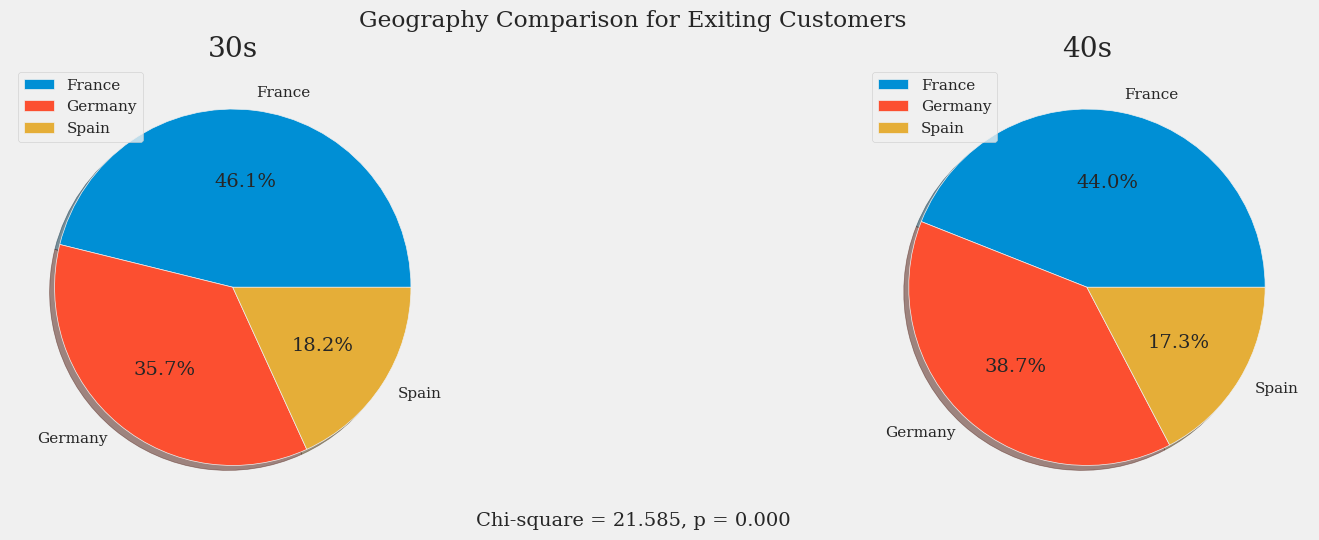

In [ ]:
# Compare Geography for customers who exited in their 30s and 40s

# Importing the necessary library
import matplotlib.pyplot as plt

# Create a 1x2 subplot grid
fig, ax = plt.subplots(1, 2, figsize=(18, 5.5))

# Iterate over age groups
for i, (age_group, exited_data) in enumerate([('30s', exited_30s), ('40s', exited_40s)]):
    # Plot pie chart for Geography in each age group
    exited_data['Geography'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[i], shadow=True)
    ax[i].set_title(f'{age_group}')
    ax[i].set_ylabel('')

    # Add legend at the top-left corner
    labels = ['France', 'Germany', 'Spain']
    ax[i].legend(labels, loc='upper left')

# Add text below the center of the figure
fig.text(0.5, 0.05, f'Chi-square = {chi2_geography:.3f}, p = {p_geography:.3f}', ha='center', va='center')

# Set the overall title for the entire figure
plt.suptitle('Geography Comparison for Exiting Customers')
plt.show()

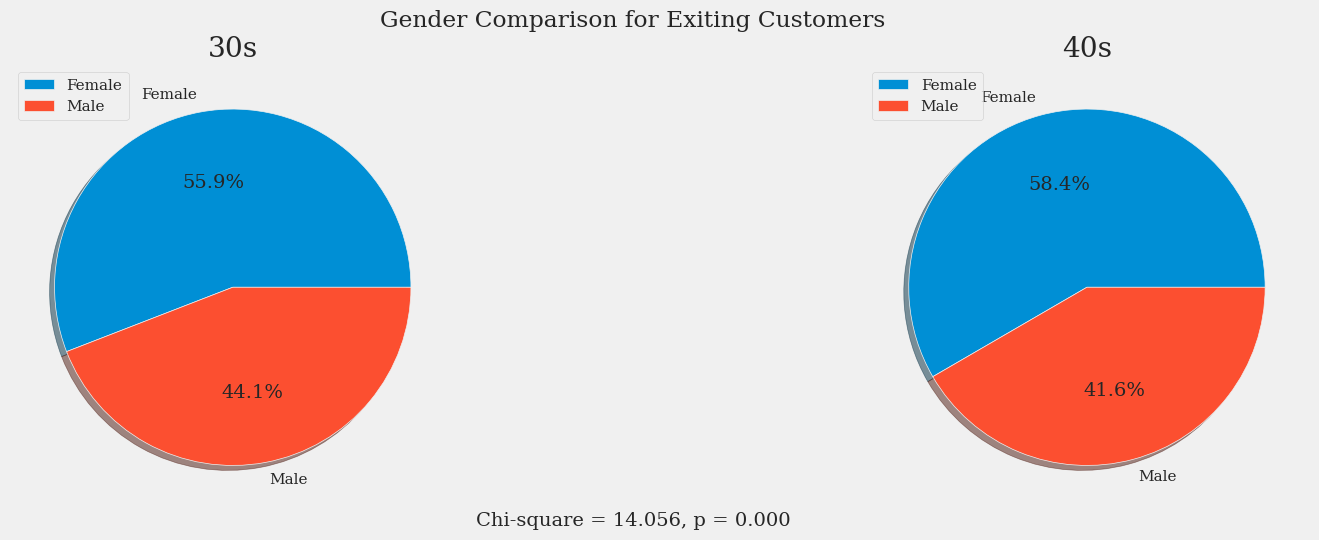

In [ ]:
# Compare Gender for customers who exited in their 30s and 40s

# Importing the necessary library
import matplotlib.pyplot as plt

# Create a 1x2 subplot grid
fig, ax = plt.subplots(1, 2, figsize=(18, 5.5))

# Iterate over age groups
for i, (age_group, exited_data) in enumerate([('30s', exited_30s), ('40s', exited_40s)]):
    # Plot pie chart for Gender in each age group
    exited_data['Gender'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[i], shadow=True)
    ax[i].set_title(f'{age_group}')
    ax[i].set_ylabel('')

    # Add legend at the top-left corner
    labels = ['Female', 'Male']
    ax[i].legend(labels, loc='upper left')

# Add text below the center of the figure
fig.text(0.5, 0.05, f'Chi-square = {chi2_gender:.3f}, p = {p_gender:.3f}', ha='center', va='center')

# Set the overall title for the entire figure
plt.suptitle('Gender Comparison for Exiting Customers')
plt.show()

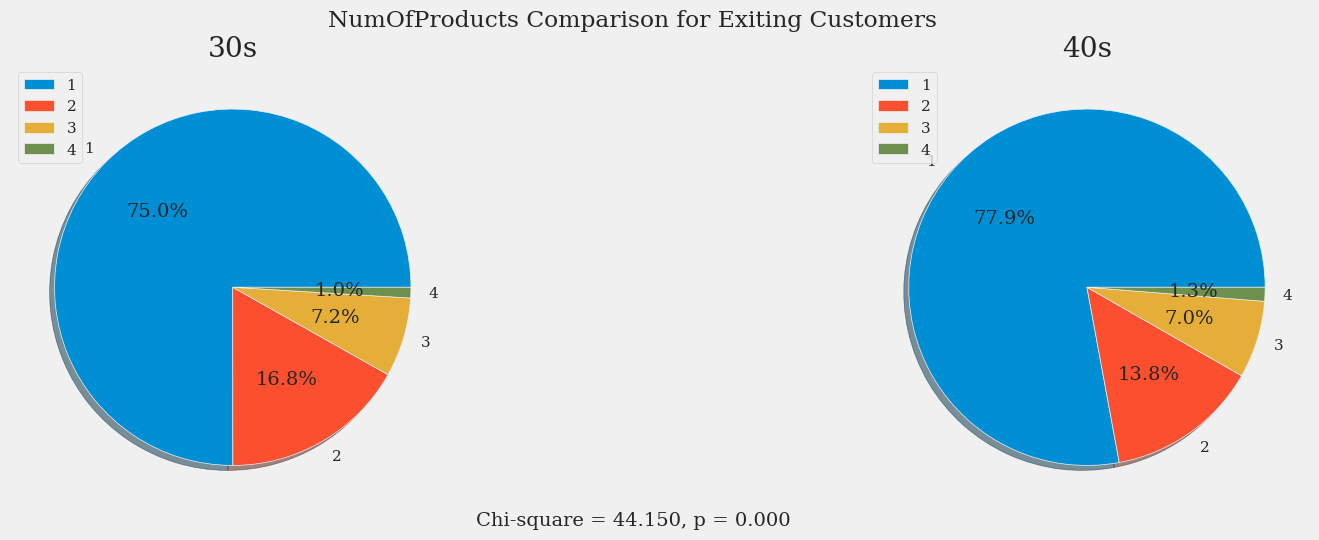

In [ ]:
# Compare NumOfProducts for customers who exited in their 30s and 40s

# Create a 1x2 subplot grid
fig, ax = plt.subplots(1, 2, figsize=(18, 5.5))

# Iterate over age groups
for i, (age_group, exited_data) in enumerate([('30s', exited_30s), ('40s', exited_40s)]):
    # Plot pie chart for Gender in each age group
    exited_data['NumOfProducts'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[i], shadow=True)
    ax[i].set_title(f'{age_group}')
    ax[i].set_ylabel('')

    # Add legend at the top-left corner
    labels = ['1', '2', '3', '4']
    ax[i].legend(labels, loc='upper left')

# Add text below the center of the figure
fig.text(0.5, 0.05, f'Chi-square = {chi2_products:.3f}, p = {p_products:.3f}', ha='center', va='center')

# Set the overall title for the entire figure
plt.suptitle('NumOfProducts Comparison for Exiting Customers')
plt.show()

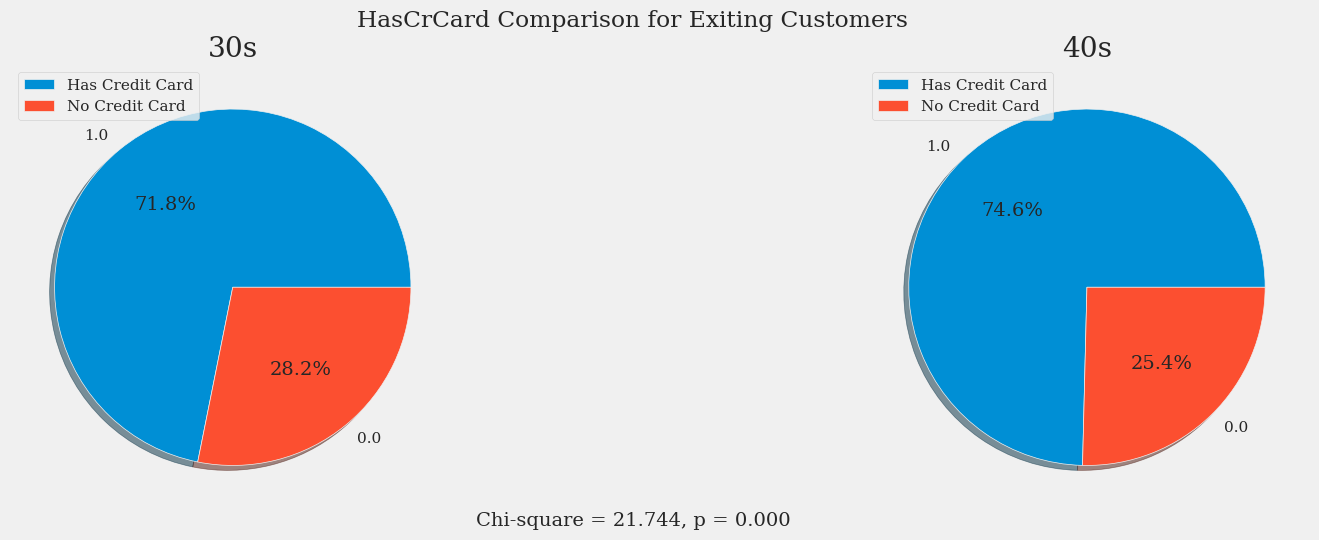

In [ ]:
# Compare HasCrCard for customers who exited in their 30s and 40s

# Create a 1x2 subplot grid
fig, ax = plt.subplots(1, 2, figsize=(18, 5.5))

# Iterate over age groups
for i, (age_group, exited_data) in enumerate([('30s', exited_30s), ('40s', exited_40s)]):
    # Plot pie chart for Gender in each age group
    exited_data['HasCrCard'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[i], shadow=True)
    ax[i].set_title(f'{age_group}')
    ax[i].set_ylabel('')

    # Add legend at the top-left corner
    labels = ['Has Credit Card', 'No Credit Card']
    ax[i].legend(labels, loc='upper left')

# Add text below the center of the figure
fig.text(0.5, 0.05, f'Chi-square = {chi2_crcard:.3f}, p = {p_crcard:.3f}', ha='center', va='center')

# Set the overall title for the entire figure
plt.suptitle('HasCrCard Comparison for Exiting Customers')
plt.show()

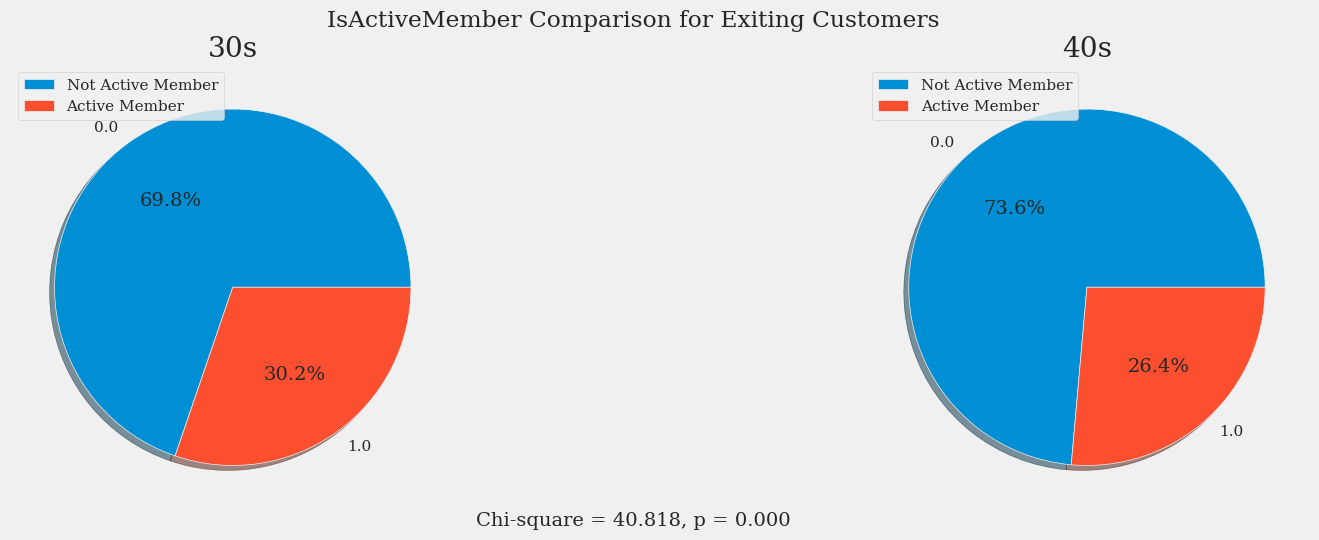

In [ ]:
# Compare IsActiveMember for customers who exited in their 30s and 40s

# Create a 1x2 subplot grid
fig, ax = plt.subplots(1, 2, figsize=(18, 5.5))

# Iterate over age groups
for i, (age_group, exited_data) in enumerate([('30s', exited_30s), ('40s', exited_40s)]):
    # Plot pie chart for Gender in each age group
    exited_data['IsActiveMember'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[i], shadow=True)
    ax[i].set_title(f'{age_group}')
    ax[i].set_ylabel('')

    # Add legend at the top-left corner
    labels = ['Not Active Member', 'Active Member']
    ax[i].legend(labels, loc='upper left')

# Add text below the center of the figure
fig.text(0.5, 0.05, f'Chi-square = {chi2_active:.3f}, p = {p_active:.3f}', ha='center', va='center')

# Set the overall title for the entire figure
plt.suptitle('IsActiveMember Comparison for Exiting Customers')
plt.show()

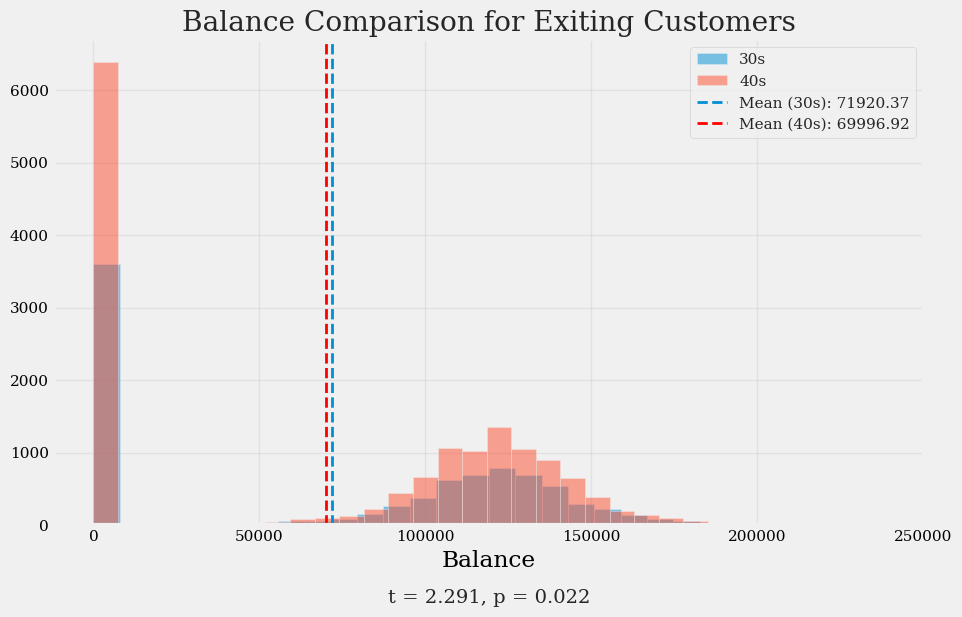

In [ ]:
# Compare Balance for customers who exited in their 30s and 40s

# Importing the necessary library
import matplotlib.pyplot as plt

# Calculate mean values for Balance
balance_mean_30s = round(exited_30s['Balance'].mean(), 2)
balance_mean_40s = round(exited_40s['Balance'].mean(), 2)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histograms for Balance in their 30s and 40s
ax.hist(exited_30s['Balance'], bins=30, alpha=0.5, label='30s')
ax.hist(exited_40s['Balance'], bins=30, alpha=0.5, label='40s')

# Add dashed lines for mean values
ax.axvline(balance_mean_30s, linestyle='dashed', linewidth=2, label=f'Mean (30s): {balance_mean_30s}')
ax.axvline(balance_mean_40s, color='red', linestyle='dashed', linewidth=2, label=f'Mean (40s): {balance_mean_40s}')

# Set title and labels
ax.set_title('Balance Comparison for Exiting Customers')
ax.set_xlabel('Balance')
ax.set_ylabel('')
ax.legend()

# Add text below the center of the figure
ax.text(0.5, -0.15, f't = {t_balance:.3f}, p = {p_balance:.3f}', ha='center', va='center', transform=ax.transAxes)

# Show the plot
plt.show()

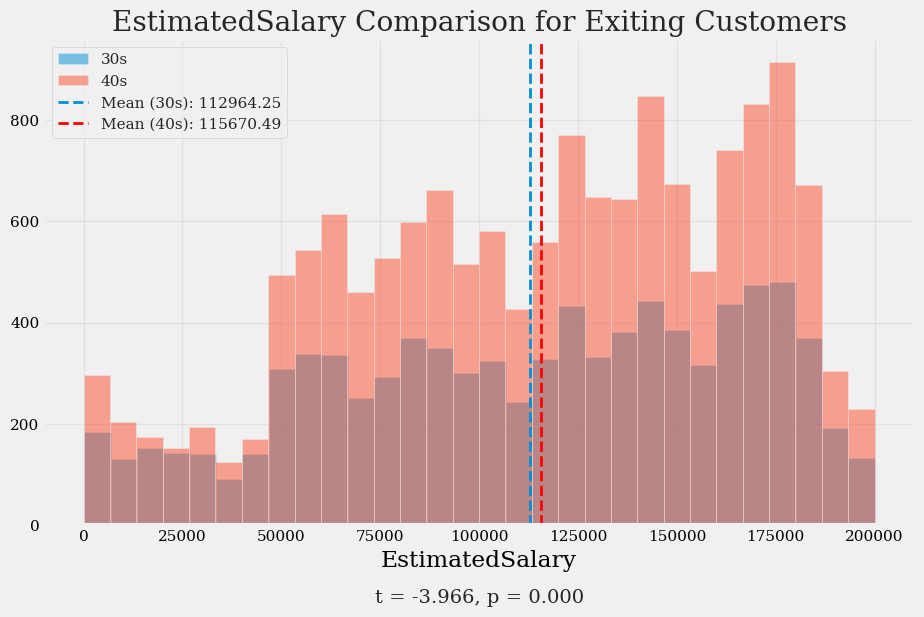

In [ ]:
# Compare EstimatedSalary for customers who exited in their 30s and 40s

# Importing the necessary library
import matplotlib.pyplot as plt

# Calculate mean values for EstimatedSalary
salary_mean_30s = round(exited_30s['EstimatedSalary'].mean(), 2)
salary_mean_40s = round(exited_40s['EstimatedSalary'].mean(), 2)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histograms for EstimatedSalary in their 30s and 40s
ax.hist(exited_30s['EstimatedSalary'], bins=30, alpha=0.5, label='30s')
ax.hist(exited_40s['EstimatedSalary'], bins=30, alpha=0.5, label='40s')

# Add dashed lines for mean values
ax.axvline(salary_mean_30s, linestyle='dashed', linewidth=2, label=f'Mean (30s): {salary_mean_30s}')
ax.axvline(salary_mean_40s, color='red', linestyle='dashed', linewidth=2, label=f'Mean (40s): {salary_mean_40s}')

# Set title and labels
ax.set_title('EstimatedSalary Comparison for Exiting Customers')
ax.set_xlabel('EstimatedSalary')
ax.set_ylabel('')
ax.legend()

# Add text below the center of the figure
ax.text(0.5, -0.15, f't = {t_salary:.3f}, p = {p_salary:.3f}', ha='center', va='center', transform=ax.transAxes)

# Show the plot
plt.show()